# Title

Author: Sandra Godinho Silva \
Most updated version: 0.1 (1/01/2021)

## Purpose
State the purpose of the notebook.

## Methodology
Quickly describe assumptions and processing steps.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import matplotlib as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [ ]:
import plotly.express as px

## Local library import
We import all the required local libraries libraries

In [2]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries

In [3]:
import numpy as np
from sklearn import model_selection

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import label_binarize


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold,  GridSearchCV



from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression

import numpy as np

from sklearn.svm import SVC

from sklearn.multiclass import OneVsRestClassifier

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [4]:
num_runs = 1 #int(config.get('Evaluation', 'NumberRuns'))
num_test = 3
normalization = "Standard"

train_rf = "True"
train_logistic_regression = "False"
train_svm = "True"

# RF
NumberTrees = 500 
ValidationModels =  5

# SVM
GridCV = 5
MaxIterations = 1000

In [5]:
to_train = []

if train_rf == "True":
    to_train.append("RF")
if train_logistic_regression == "True":
    to_train.append("Logistic Regression")
if train_svm == "True":
    to_train.append("SVM")
    
# Set up DataFrames to store results
cv_list = ["Run_" + str(x) + "_CV_" + str(y) for x in range(num_runs) for y in range(num_test)]
auc_df = pd.DataFrame(index=to_train, columns=cv_list)
mcc_df = pd.DataFrame(index=to_train, columns=cv_list)
precision_df = pd.DataFrame(index=to_train, columns=cv_list)
recall_df = pd.DataFrame(index=to_train, columns=cv_list)
f1_df = pd.DataFrame(index=to_train, columns=cv_list)

# Functions

In [6]:
# Hyperparameter tunning for Random Forest
def parameter_tunning_RF():
    # number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    
    # number of features at every split
    max_features = ["auto", "sqrt"]

    # max depth
    max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
    max_depth.append(None)
    
    # create random grid
    random_grid = {
     "n_estimators": n_estimators,
     "max_features": max_features,
     "max_depth": max_depth
     }
    
    rfc = RandomForestClassifier()
    # Random search of parameters
    #In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings 
    #is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.
    rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    # Fit the model
    rfc_random.fit(X_train, y_train)
       
    best_parameters = rfc_random.best_params_
    print(best_parameters)
    
    return best_parameters

In [7]:
# Hyperparameter tunning for SVM - Grid Search
def parameter_tunning_SVM():

    # create random grid
    random_grid = {'C': [0.1,1, 10, 100], 
                  'gamma': [1,0.1,0.01,0.001],
                 'kernel'  : ['linear','rbf', 'poly', 'sigmoid']}
    
    svm = SVC()
    # Random search of parameters
    #In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings 
    #is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.
    svc_random = RandomizedSearchCV(estimator = svm, param_distributions = random_grid, n_iter = 100, cv = 3, 
                                    verbose=2, random_state=42, n_jobs = -1)
    
    # Fit the model
    svc_random.fit(X_train, y_train)
       
    best_paramters = svc_random.best_params_
    print(best_paramters)
    
    return best_paramters


# Data import
We retrieve all the required data for the analysis.

In [8]:
#df = pd.read_csv("cog_genus_counts.csv", index_col=0)
df=pd.read_csv("cazymes_PA_metadata.csv")
df.head()

,GT2_Glycos_transf_2,GT9,GT4,GT5,GT25,GH30_1,GH3,GH144,GT51,GH25,CBM50+GH73,CBM32+GH2,GH2,GH109,GT19,GT83,CE11,GH13,GH65,GH97,GH13_19,GT2,CE14,GH92,GT28,...,GH92+GH92,CBM3+GH74,GH5_36,GH102,GH18+CBM6,GH16+GT25,GH123+GH123,CBM35+CBM57+CBM6,CE4+GT2_Glycos_transf_2,GH20+CBM32+CBM5,CE1+CE1,GH39+CBM6,GH81,AA4,CBM32+PL6,CBM77,CBM6+GH3,GH51+CBM35,GH18+CBM73,CBM32+PL7_5,PL7_5+4.2.2.3,CBM47+PL7_3,CBM16+CBM47+PL7_3,CBM47+CBM6+CBM47+CBM6,Origin
0,1,1,1,1,0,0,1,0,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Non_marine
1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marine
2,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,1,1,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marine
3,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marine
4,1,0,1,1,0,1,1,0,1,0,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Non_marine


In [9]:
category= "Origin"
X = df.copy()
y = X.pop(category).values

# Stratified k-fold needs np arrays
X = X.to_numpy()

In [10]:
def get_stats(y_test, pred, fitted):
    stat_dict = {}
    stat_dict["Accuracy"] = accuracy_score(y_test, pred)
    stat_dict["MCC"] = matthews_corrcoef(y_test, pred)
    stat_dict["Precision"] = precision_score(y_test, pred, average='weighted')
    stat_dict["Recall"] = recall_score(y_test, pred, average='weighted')
    stat_dict["F1"] = f1_score(y_test, pred, average='weighted')

    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    if num_class == 2:
        stat_dict["AUC"] = roc_auc_score(y_test, fitted.predict_proba(X_test)[:,1], average='weighted')
    else:
        stat_dict["AUC"] = roc_auc_score(y_test, fitted.predict_proba(X_test), average='weighted')   
    
    return stat_dict

In [11]:
features = df.select_dtypes(include=['int']).columns
num_class = len(np.unique(y))

rf_scores = pd.DataFrame(index=features)

if num_class == 2:
    svm_scores = pd.DataFrame(index=features)
    logistic_regression_scores = pd.DataFrame(index=features)

else:
    svm_scores = {}
    logistic_regression_scores = {}
    for l in label_set:
        svm_scores[l] = pd.DataFrame(index=features)     
        logistic_regression_scores[l] = pd.DataFrame(index=features) 

In [12]:
normalization="Standard"
num_test=3
seeds = np.random.randint(1000, size=num_runs)
run = 0

for seed in seeds:
    print("Starting CV")
    #Provides train/test indices to split data in train/test sets.
    skf = StratifiedKFold(n_splits=num_test, shuffle=True, random_state=seed)
    fold = 0
    
    # Hypertunning before K folds - Random Forest
    try: # If it was run before, don't run again
        best_rf_parameters
    except:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)
        best_rf_parameters = parameter_tunning_RF()
    print("RandomSearchCV best parameters for Random Forest: " + str(best_rf_parameters))
        
    # Hypertunning before K folds - Random Forest
    try: # If it was run before, don't run again
        best_svm_parameters
    except:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)
        best_svm_parameters = parameter_tunning_SVM()
    print("RandomSearchCV best parameters for SVM: " + str(best_svm_parameters))
    
    # Stratified k-fold
    for train_index, test_index in skf.split(X, y):
        # Select and format training and testing sets
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        
        cl =  np.unique(y_train)
        num_class = len(cl)
        
        ###################################################################################
        # RANDOM FOREST
        if train_rf == "True":
        # Already use best parameters from Hyperparameter tunning
            rfc = RandomForestClassifier(n_estimators=best_rf_parameters["n_estimators"], 
                                         max_features=best_rf_parameters["max_features"], 
                                         max_depth=best_rf_parameters["max_depth"])

            # Fit model
            rfc.fit(X_train,y_train)
        
            # Get predicted labels for the test data:
            rfc_predict = rfc.predict(X_test)

            # Get ranking of feature importance
            feature_importance = rfc.feature_importances_
        
            stat_dict = get_stats(y_test, rfc_predict, rfc)
            
            rf_scores["Run_" + str(run) + "_CV_" + str(fold)] = feature_importance
        
            auc_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["AUC"]
            mcc_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["MCC"]
            precision_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["Precision"]
            recall_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["Recall"]
            f1_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["F1"]

            sys.stdout.write("")
            print("# RF:\t\t\t%f\t%f" % (stat_dict["AUC"], auc_df.loc["RF"].mean(axis=0)))    
        
        ###################################################################################
        # SUPPORT VECTOR MACHINES
        if train_svm == "True":
            #num_cv = GridCV
            #max_iter = MaxIterations  
            
            clf = SVC(kernel=best_svm_parameters["kernel"],
                      C = best_svm_parameters["C"],
                      gamma = best_svm_parameters["gamma"],
                      probability=True)
            
            # Fit model
            clf.fit(X_train,y_train)
            
            # Get predicted labels for the test data:
            svm_pred = clf.predict(X_test)
            
            stat_dict = get_stats(y_test, svm_pred, clf)
            
            auc_df.loc["SVM"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["AUC"]
            mcc_df.loc["SVM"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["MCC"]
            precision_df.loc["SVM"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["Precision"]
            recall_df.loc["SVM"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["Recall"]
            f1_df.loc["SVM"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["F1"]

            sys.stdout.write("")
            print("# SVM:\t\t\t%f\t%f" % (stat_dict["AUC"], auc_df.loc["SVM"].mean(axis=0)))  
    
        fold +=1
    run +=1

Starting CV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


{'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 460}
RandomSearchCV best parameters for Random Forest: {'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 460}
Fitting 3 folds for each of 64 candidates, totalling 192 fits


/home/sandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   10.1s finished


{'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
RandomSearchCV best parameters for SVM: {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
# RF:			0.905603	0.905603
# SVM:			0.896293	0.896293
# RF:			0.935295	0.920449
# SVM:			0.928226	0.912259
# RF:			0.906865	0.915921
# SVM:			0.896870	0.907129


In [29]:
auc_df.to_csv("Evaluation_dfs/auc_df.csv")
mcc_df.to_csv("Evaluation_dfs/mcc_df.csv")
precision_df.to_csv("Evaluation_dfs/precision_df.csv")
recall_df.to_csv("Evaluation_dfs/recall_df.csv")
f1_df.to_csv("Evaluation_dfs/f1_df.csv")


In [13]:
results_df = pd.DataFrame(index=["AUC", "MCC", "Precision", "Recall", "F1"], columns=to_train)
results_df_nr = pd.DataFrame(index=["AUC", "MCC", "Precision", "Recall", "F1"], columns=to_train)

for model in to_train:
    results_df.loc["AUC"][model] = "{:.2f}".format(auc_df.loc[model].mean())+ " (" + "{:.2f}".format(auc_df.loc[model].std()) + ")"     
    results_df_nr.loc["AUC"][model] = auc_df.loc[model].mean()   
    
    results_df.loc["MCC"][model] = "{:.2f}".format(mcc_df.loc[model].mean()) + " (" + "{:.2f}".format(mcc_df.loc[model].std()) + ")"
    results_df_nr.loc["MCC"][model] = mcc_df.loc[model].mean()   
    
    results_df.loc["Precision"][model] = "{:.2f}".format(precision_df.loc[model].mean()) + " (" + "{:.2f}".format(precision_df.loc[model].std()) + ")"
    results_df_nr.loc["Precision"][model] = precision_df.loc[model].mean()   

    results_df.loc["Recall"][model] = "{:.2f}".format(recall_df.loc[model].mean()) + " (" + "{:.2f}".format(recall_df.loc[model].std()) + ")"
    results_df_nr.loc["Recall"][model] = recall_df.loc[model].mean()   

    results_df.loc["F1"][model] = "{:.2f}".format(f1_df.loc[model].mean()) + " (" + "{:.2f}".format(f1_df.loc[model].std()) + ")"
    results_df_nr.loc["F1"][model] = f1_df.loc[model].mean()   

# Find model with best metrics    
results_df_nr.loc["Total",:] = results_df_nr.sum(axis=0).divide(5).round(2)

best={}
for model in to_train:
    best[model] = results_df_nr.loc["Total",:][model]
    
best_model = max(best, key=best.get)

print("Results - mean & standard deviation values per model: ")
print(results_df.head(20))
print("")
print("Best model: " + str(best_model))

Results - mean & standard deviation values per model: 
                    RF          SVM
AUC        0.92 (0.02)  0.91 (0.02)
MCC        0.75 (0.05)  0.68 (0.03)
Precision  0.88 (0.03)  0.85 (0.02)
Recall     0.88 (0.03)  0.85 (0.02)
F1         0.88 (0.03)  0.84 (0.02)

Best model: RF


In [22]:
def generate_boxplot(): #to_train, num_class, auc_df, mcc_df, precision_df, recall_df, f1_df, results_path

    fig = px.box(pd.melt(auc_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of AUC",
             labels={"value": "AUC",
                     "variable": "Model"})
    fig.show()
    
    fig = px.box(pd.melt(mcc_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of MMC",
             labels={"value": "MMC",
                     "variable": "Model"})
    fig.show()
    
    fig = px.box(pd.melt(precision_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of Precision measure",
             labels={"value": "Precision",
                     "variable": "Model"})
    fig.show()
    
    fig = px.box(pd.melt(recall_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of Recall measure",
             labels={"value": "Recall",
                     "variable": "Model"})
    fig.show()
    
    fig = px.box(pd.melt(f1_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of F1",
             labels={"value": "F1",
                     "variable": "Model"})
    fig.show()
    

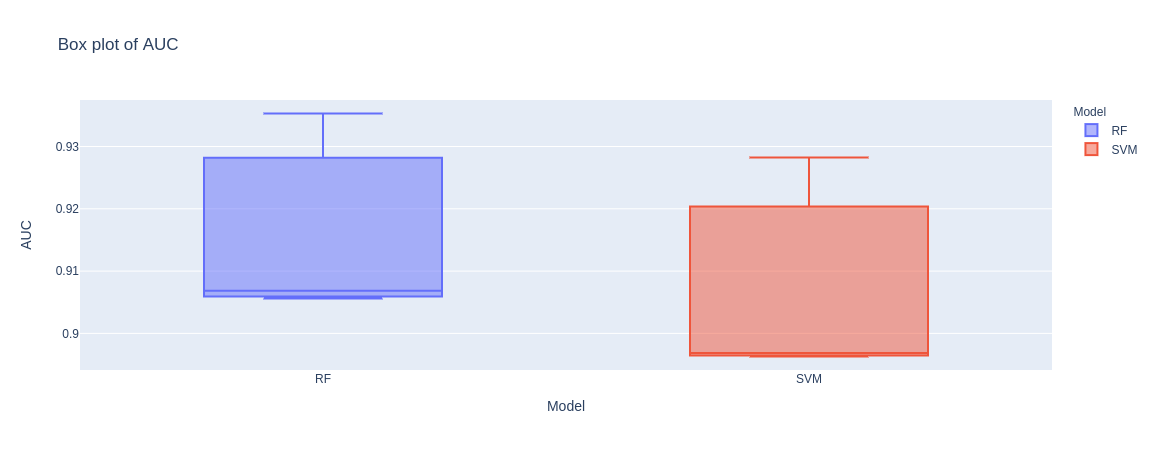

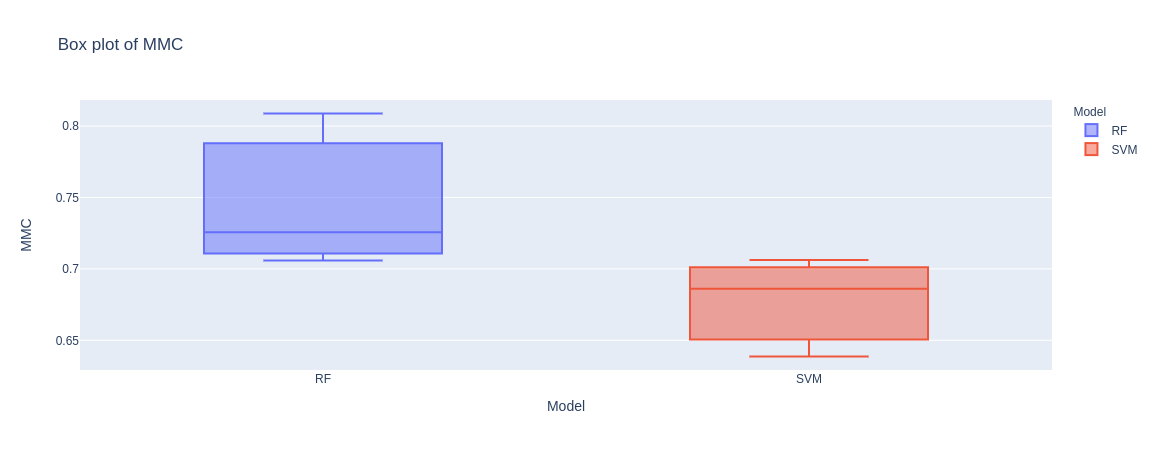

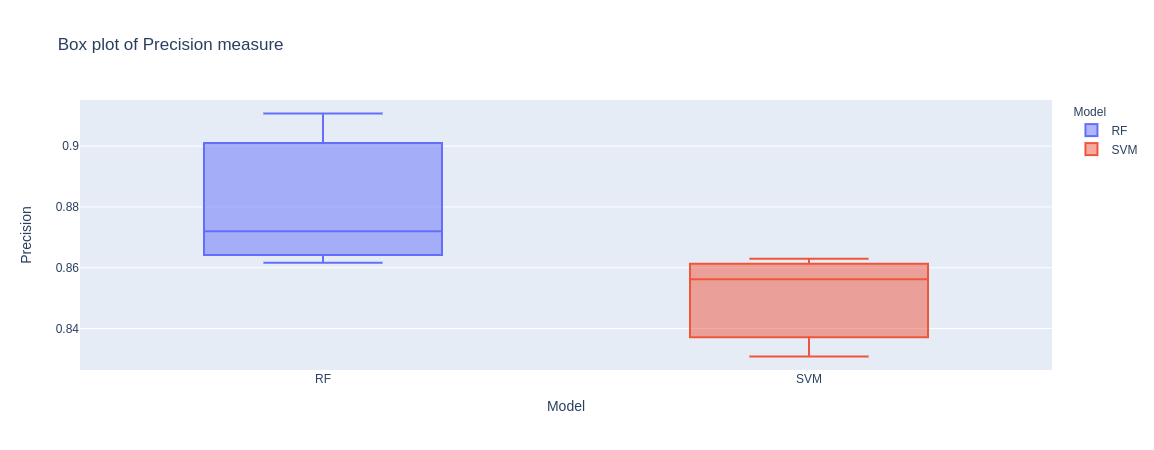

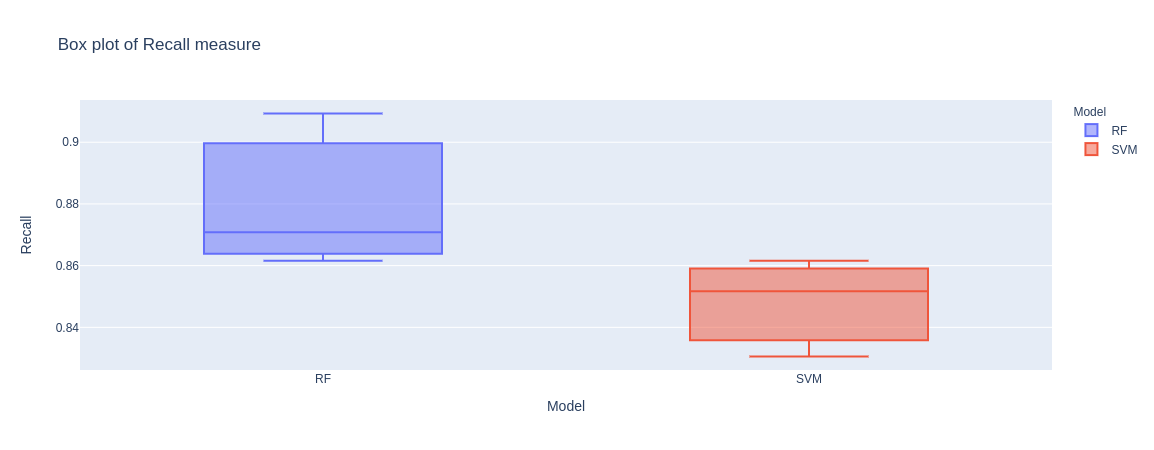

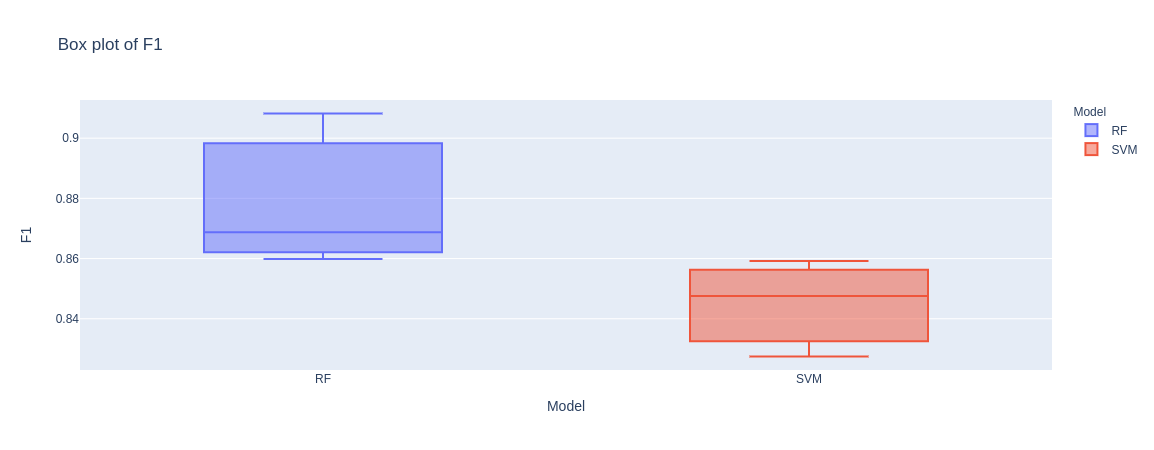

In [23]:
generate_boxplot()

In [15]:
pd.melt(recall_df.transpose())

,variable,value
0,RF,0.861575
1,RF,0.909308
2,RF,0.870813
3,SVM,0.830549
4,SVM,0.861575
5,SVM,0.851675


In [43]:
df = recall_df.T.reset_index()
df[df["index"]== "Run_0_CV_0"]

,index,RF,SVM
0,Run_0_CV_0,0.861575,0.830549


In [72]:
df = results_df_nr.T.drop(columns="Total").T
#df = df.reset_index().rename(columns={"index":"Model"})
df.head()

,RF,SVM
AUC,0.915921,0.907129
MCC,0.746741,0.67697
Precision,0.881445,0.849998
Recall,0.880565,0.847933
F1,0.878949,0.844743


In [ ]:
rf_median_scores

In [ ]:
labels_data, label_set = pd.factorize(y)

In [24]:
# Feature Selection implementation
if best_model == "RF":
    rfc = RandomForestClassifier(n_estimators=best_rf_parameters["n_estimators"], 
                                         max_features=best_rf_parameters["max_features"], 
                                         max_depth=best_rf_parameters["max_depth"])
    # Fit model
    rfc.fit(X_train,y_train)
        
    # Get predicted labels for the test data:
    rfc_predict = rfc.predict(X_test)

    # Cross-validation
    scores = cross_val_score(rfc, X, y, cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    # Get ranking of feature importance
    feature_importance = rfc.feature_importances_
        
    stat_dict_final = get_stats(y_test, rfc_predict, rfc)
            
elif best_model == "SVM":
    
    clf = SVC(kernel=best_svm_parameters["kernel"],
                      C = best_svm_parameters["C"],
                      gamma = best_svm_parameters["gamma"],
                      probability=True)
    clf.fit(X_train,y_train)
    
    scores = cross_val_score(clf, X, y, cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    svm_pred = clf.predict(X_test)
        
rf_scores["Run_" + str(run) + "_CV_" + str(fold)] = feature_importance
        
auc_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["AUC"]
mcc_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["MCC"]
precision_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["Precision"]
recall_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["Recall"]
f1_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["F1"]

sys.stdout.write("")
print(str(best_model) + " AUC: " + str(stat_dict_final["AUC"]))

0.88 accuracy with a standard deviation of 0.01
RF AUC: 0.9055386766975309


In [25]:
ranking_df = pd.DataFrame(index=range(len(features)))

rf_ranking_df = pd.DataFrame(index=range(len(features)))
svm_ranking_df = pd.DataFrame(index=range(len(features)))

model_rankings = {}
        
if "RF" in to_train:
    for col in rf_scores.columns:
        rank_list = rf_scores[col].rank(ascending=False).sort_values(ascending=True).index.values
        ranking_df["RF_" + col] = rank_list
        rf_ranking_df["RF_" + col] = rank_list
    model_rankings["RF"] = rf_scores.median(axis=1).sort_values(ascending=False).index.values
    
if "SVM" in to_train and num_class == 2:
    for col in svm_scores.columns:
        rank_list = svm_scores[col].abs().rank(ascending=False).sort_values(ascending=True).index.values
        ranking_df["SVM_" + col] = rank_list
        svm_ranking_df["SVM_" + col] = rank_list
    model_rankings["SVM"] = svm_scores.median(axis=1).sort_values(ascending=False).index.values

elif "SVM" in to_train and num_class > 2:
    svm_joint_scores = pd.DataFrame(index=features, columns=svm_ranking_df.columns)
    for col in svm_scores[label_set[0]].columns:
        for l in range(len(label_set)):
            if l == 0:
                score_list = svm_scores[label_set[l]][[col]]
            else:
                score_list = score_list.join(svm_scores[label_set[l]][[col]], rsuffix=l)
        ranking_df["SVM_" + col] = score_list.abs().mean(axis=1).rank(ascending=False).sort_values(ascending=True).index.values
        svm_ranking_df["SVM_" + col] = score_list.abs().mean(axis=1).rank(ascending=False).sort_values(ascending=True).index.values
        svm_joint_scores["SVM_" + col] = score_list.abs().mean(axis=1)
            
        for l in range(len(label_set)):
            if l == 0:
                score_list = svm_scores[label_set[l]].abs()
            else:
                score_list = score_list.join(svm_scores[label_set[l]].abs(), rsuffix=l)            
    model_rankings["SVM"] = score_list.abs().mean(axis=1).sort_values(ascending=False).index.values

In [26]:
pd.DataFrame.from_dict(model_rankings)

,RF,SVM
0,GH25,GT2_Glycos_transf_2
1,GH113,GT9
2,GT83,GT4
3,CBM9,GT5
4,CE4,GT25
...,...,...
744,GH141+CBM16,CBM32+PL7_5
745,CE3,PL7_5+4.2.2.3
746,CBM6+CBM6+CBM6+CBM6,CBM47+PL7_3
747,GH27+CBM13,CBM16+CBM47+PL7_3


In [ ]:

    import matplotlib.pyplot as plt
    import seaborn as sns
    if "RF" in to_train:
        rf_median_scores = rf_scores.median(axis=1)        
        fig = plt.figure(dpi=300, figsize=(9,9), tight_layout=True)
        
        plt.ylabel("Density")
        plt.xlabel("Score")
        plt.title("RF Feature Scores")
        sns.distplot(list(rf_median_scores))
        plt.savefig("RF_scores.png")
        #plt.clf()